Results Comparison: LSTM vs TF

In [1]:
import pandas as pd
import numpy as np
import torch

import os
import sys
sys.path.append(os.getenv("PROJECT_PATH"))

df = pd.read_csv('../../data/train/ss1.csv')

In [2]:
# Remove a coluna de índice de tempo para focar nas posições
df = df.drop(columns=["frame_index"])

# Lista de entidades (jogadores + bola)
entity_names = df.columns.tolist()
n_entities = len(entity_names)
n_frames = len(df)

# Função para converter string "x,y" em vetor [x, y]
def parse_position(pos_str):
    try:
        x, y = map(float, pos_str.split(','))
        return np.array([x, y])
    except:
        return np.array([np.nan, np.nan])  # Para valores ausentes

# Inicializar e preencher matriz de posições
positions_array = np.zeros((n_frames, n_entities, 2))
for i, entity in enumerate(entity_names):
    positions_array[:, i, :] = np.stack(df[entity].apply(parse_position).values)

# Interpolar valores ausentes
def interpolate_array(array):
    for entity_idx in range(n_entities):
        for coord in range(2):
            series = array[:, entity_idx, coord]
            mask = np.isnan(series)
            not_nan = np.where(~mask)[0]
            if len(not_nan) > 1:
                array[:, entity_idx, coord] = np.interp(
                    x=np.arange(n_frames),
                    xp=not_nan,
                    fp=series[not_nan]
                )
            else:
                array[:, entity_idx, coord] = 0.0
    return array

positions_array = interpolate_array(positions_array)

# Normalizar posições
min_pos = np.nanmin(positions_array, axis=(0, 1))
max_pos = np.nanmax(positions_array, axis=(0, 1))
range_pos = max_pos - min_pos
range_pos[range_pos == 0] = 1.0
positions_array_norm = (positions_array - min_pos) / range_pos

# Criar máscara de presença
def generate_mask(df, entity_names):
    mask = np.ones((n_frames, n_entities), dtype=np.float32)
    for i, entity in enumerate(entity_names):
        for t in range(n_frames):
            if pd.isna(df.iloc[t][entity]):
                mask[t, i] = 0.0
    return mask

mask_array = generate_mask(df, entity_names)

# Parâmetros da sequência
N, M = 10, 5
num_samples = n_frames - N - M + 1
X_norm = np.zeros((num_samples, N, n_entities, 2))
Y_norm = np.zeros((num_samples, M, n_entities, 2))
X_mask = np.zeros((num_samples, N, n_entities))
Y_mask = np.zeros((num_samples, M, n_entities))

for i in range(num_samples):
    X_norm[i] = positions_array_norm[i:i+N]
    Y_norm[i] = positions_array_norm[i+N:i+N+M]
    X_mask[i] = mask_array[i:i+N]
    Y_mask[i] = mask_array[i+N:i+N+M]


TRANSFORMER

In [4]:
import ast
import numpy as np
import supervision as sv

from notebooks.predictions.TF.trajectorytransformer import TrajectoryTransformer
from notebooks.predictions.TF.trajectorydataset import TrajectoryDataset

from utils.drawpitch import draw_pitch, draw_paths_on_pitch
from utils.pitchconfig import SoccerPitchConfiguration

# === Configuração do campo e Modelo ===
CONFIG = SoccerPitchConfiguration()
annotated_frame = draw_pitch(CONFIG)

model = TrajectoryTransformer()
model.load_state_dict(torch.load('../../data/models/trajectory_transformer.pth', map_location='cpu'))
model.eval()

# Player a ser previsto
player_col = 'id_1_team_1'

# Últimos 10 frames de entrada usados para prever os próximos 5
N, M = 10, 5
actual_col_xy = (
    df[player_col]
    .iloc[-(N+M):-M]  # frames de entrada
    .dropna()
    .str.replace(';', ',')
    .apply(ast.literal_eval)
    .to_list()
)
actual_traj = np.array(actual_col_xy)

# === Prepara sample_X para todos os jogadores ===
entity_names = df.columns.tolist()
num_players = len(entity_names)

# Supondo que as colunas de jogadores começam com 'id_' (ajuste conforme seu caso)
entity_names = [col for col in df.columns if col.startswith('id_')]
num_players = len(entity_names)

# Verifique se player_col está em entity_names
if player_col not in entity_names:
    raise ValueError(f"{player_col} não está em entity_names. Corrija player_col ou o filtro de entity_names.")

sample_X = []
for col in entity_names:
    traj = (
        df[col]
        .iloc[-(N+M):-M]
        .dropna()
        .apply(lambda x: ast.literal_eval(str(x).replace(';', ',')))
        .to_list()
    )
    traj = [list(map(float, t)) if isinstance(t, (list, tuple)) and len(t) == 2 else [0.0, 0.0] for t in traj]
    while len(traj) < N:
        traj.insert(0, [0.0, 0.0])
    traj = traj[:N]
    sample_X.append(traj)

sample_X = np.array(sample_X, dtype=np.float32)
sample_X = np.transpose(sample_X, (1, 0, 2))
sample_X = torch.tensor(sample_X, dtype=torch.float32).unsqueeze(0)

device = torch.device('cpu')  # ou 'cuda' se disponível

# === Previsão com o modelo ===
with torch.no_grad():
    pred_Y = model(sample_X.to(device))  # (1, 5, num_players, 2)
    FIELD_WIDTH = 12000
    FIELD_HEIGHT = 7000
    scale = torch.tensor([[[[FIELD_WIDTH, FIELD_HEIGHT]]]]).to(device)
    pred_Y = pred_Y * scale

player_idx = entity_names.index(player_col)
pred_traj = pred_Y[0, :, player_idx, :].cpu().numpy()

# Debug: veja os valores previstos
print("Predicted trajectory:\n", pred_traj)
print("Shape:", pred_traj.shape)
print("Min:", np.min(pred_traj), "Max:", np.max(pred_traj))


Predicted trajectory:
 [[17086.887   6019.976 ]
 [17045.664   6050.6724]
 [17011.023   6075.585 ]
 [17130.371   6026.556 ]
 [17093.484   6051.7446]
 [17030.094   6097.198 ]
 [17012.53    6108.668 ]
 [16968.385   6138.7793]
 [16994.705   6118.609 ]
 [16936.936   6158.817 ]]
Shape: (10, 2)
Min: 6019.976 Max: 17130.371


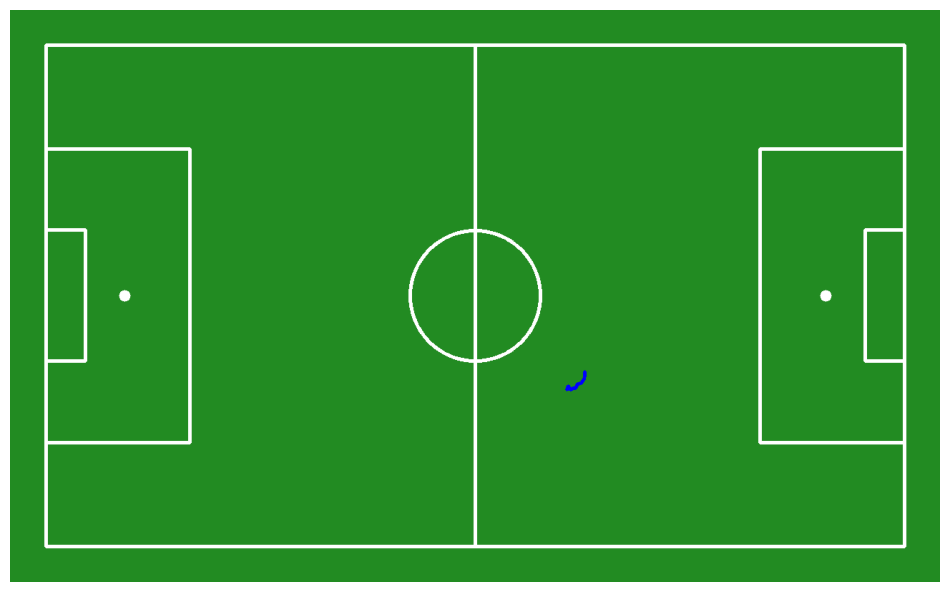

In [5]:
# Trajetorias
# Trajetória real
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[actual_traj],
    color=sv.Color.BLUE,
    thickness=4,
    pitch=annotated_frame
)

# Trajetória prevista
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[pred_traj],
    color=sv.Color.RED,
    thickness=4,
    pitch=annotated_frame
)

#Resultado
sv.plot_image(annotated_frame)